<a href="https://colab.research.google.com/github/mshassanpour/clinical-data-science-projects/blob/main/notebooks/ophthalmology_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Objective:** To develop an algorithm to segment retinal vasculature and compare your results to the manually labeled results.


The algorithm developed for segmenting retinal vasculature encompasses following steps:
1.	ROI Mask Extraction: The red channel is utilized to create an ROI (Region of Interest) mask for each image. This mask is essential for eliminating peripheral edges in the images that are occasionally misidentified as vessels.
2.	Pre-processing of Raw Images: To enhance the vascular features within the images, the following pre-processing steps were undertaken:
(i)	Adaptive Histogram Equalization with Contrast Limitation (CLAHE): After experimenting with various clipLimit values, I selected one that optimally enhances contrast without significantly amplifying noise.
(ii)	Median Filtering: A 5x5 pixel kernel was employed for median filtering to diminish noise and maintain edge integrity, achieving a balance between noise reduction and minimal blurring.
(iii)	Data Normalization: This step ensures the pixel values are normalized, setting the maximum to 1 and the minimum to 0.
(iv)	Morphological Transformation: Aimed at reducing high spatial noise, the process involved adjusting the disk size for transformation, with a final choice of disk size = 1 to avoid over-smoothing the vessels.
(v)	Gamma Correction: By adjusting the gamma value to 0.75, the contrast of dark regions, particularly vessels in green images, is significantly enhanced, improving their visibility.
(vi)	Kirsch Templates Analysis: Utilizing eight Kirsch masks, this method identifies edges in multiple directions (N, S, E, W, NE, NW, SE, and SW). The images are convolved with these masks, and the highest response for each pixel is selected, revealing the vessel edges.
(vii)	Fuzzy C-Means (FCM) Segmentation: This step employs FCM segmentation to delineate coarse vessels, further refining the vascular network's representation.
(viii)	Application of ROI Mask: to exclude edges wrongly identified as vessels during the Kirsch Templates Analysis ROI mask was applied to segmented images.

3. Segmentation Performance Evaluation: The performance of the algorithm was quantitatively evaluated by assessing its specificity, accuracy, sensitivity, and F1 score. This involved a separate comparison of the algorithm's outputs with the manual segmentation results from Graders 1 and 2.

Results:

-	While the mean accuracy was high in both comparisons, the data's imbalanced nature (i.e., a smaller portion of pixels in the image represent vessels) makes accuracy an unreliable measure.
-	The low sensitivity suggests that the algorithm failed to identify many true vessel pixels, indicating a significant number of missed detections.
-	The high specificity indicates effective performance in distinguishing background pixels, showcasing the algorithm's ability to accurately identify non-vessel areas.
-	Precision is moderate, with a slight improvement observed for Grader 2. A precision rate of approximately 30% implies that the algorithm accurately identifies vessels about one-third of the time.
-	The low F1 scores highlight an imbalance between precision and sensitivity, revealing the algorithm's challenges in accurately detecting true vessels.


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Copy the data folder to Colab
!cp -r /content/drive/MyDrive/DataChallengeImages /content

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read data and Explore the images dataset

In [ ]:
import pandas as pd
import os

folder_path = '/content/DataChallengeImages'


In [ ]:
#  read csv_file containing image information
csv_file = next((f for f in os.listdir(folder_path) if f.endswith('.csv')), None)

csv_file_path = os.path.join(folder_path, csv_file)
img_info = pd.read_csv(csv_file_path)
print(img_info.info())
img_info.head(10)

# find all unique diagnoses
unique_diagnoses = img_info['Diagnosis'].unique()
print(unique_diagnoses)# find all unique diagnoses
unique_diagnoses = img_info['Diagnosis'].unique()
print(len(unique_diagnoses))
img_info.head(20)

ids_for_each_diagnosis = img_info.groupby('Diagnosis')['ID'].apply(list).reset_index(name='IDs')
print(ids_for_each_diagnosis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         20 non-null     object
 1   Diagnosis  20 non-null     object
dtypes: object(2)
memory usage: 448.0+ bytes
None
['Diabetic Retinopathy' 'Age-related Macular Degeneration'
 'Retinal Artery or Vein Occlusion' 'Retinitis' 'Normal' 'Vasculitis'
 'Hollenhorst Plaque']
7
                          Diagnosis  \
0  Age-related Macular Degeneration   
1              Diabetic Retinopathy   
2                Hollenhorst Plaque   
3                            Normal   
4  Retinal Artery or Vein Occlusion   
5                         Retinitis   
6                        Vasculitis   

                                                 IDs  
0                                 [Im 0002, Im 0003]  
1                                 [Im 0001, Im 0139]  
2                                 [Im 0319, Im 0324]  
3  [I

In [ ]:
img_info.head(10)

,ID,Diagnosis
0,Im 0001,Diabetic Retinopathy
1,Im 0002,Age-related Macular Degeneration
2,Im 0003,Age-related Macular Degeneration
3,Im 0004,Retinal Artery or Vein Occlusion
4,Im 0005,Retinal Artery or Vein Occlusion
5,Im 0044,Retinitis
6,Im 0077,Normal
7,Im 0081,Normal
8,Im 0082,Normal
9,Im 0139,Diabetic Retinopathy


['im0163.ppm', 'im0081.ppm', 'im0001.ppm', 'im0324.ppm', 'im0240.ppm', 'im0044.ppm', 'im0255.ppm', 'im0139.ppm', 'im0239.ppm', 'im0236.ppm', 'im0319.ppm', 'im0003.ppm', 'im0235.ppm', 'im0002.ppm', 'im0004.ppm', 'im0005.ppm', 'im0291.ppm', 'im0162.ppm', 'im0077.ppm', 'im0082.ppm']
20
Im 0163
Im 0081
Im 0001
Im 0324
Im 0240
Im 0044
Im 0255
Im 0139
Im 0239
Im 0236
Im 0319
Im 0003
Im 0235
Im 0002
Im 0004
Im 0005
Im 0291
Im 0162
Im 0077
Im 0082


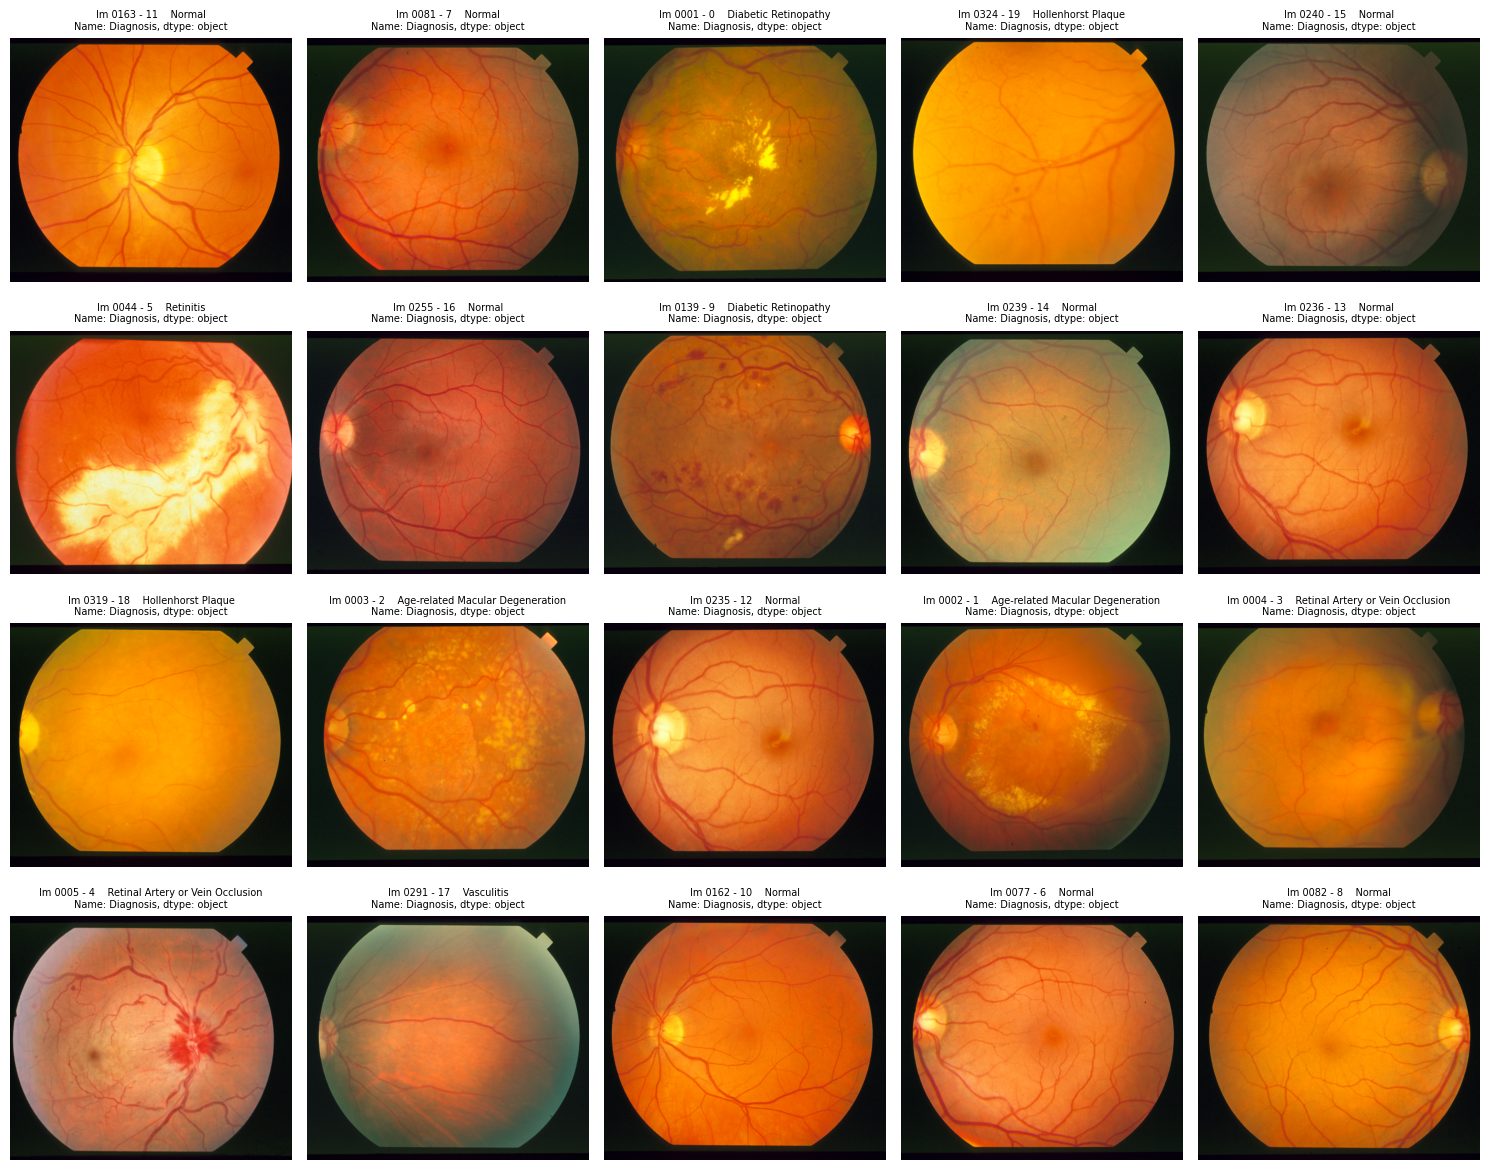

In [ ]:
# read raw data
from skimage import exposure, io
import matplotlib.pyplot as plt

folder_path_raw_Imgs = os.path.join(folder_path,'Raw images')

raw_image_files = [f for f in os.listdir(folder_path_raw_Imgs) if f.lower().endswith(('.ppm'))]

print(raw_image_files)
print(len(raw_image_files))

# visualize raw images
n_rows = 4 # Adjust based on the number of images
n_cols = 5

plt.figure(figsize=(n_cols * 3, n_rows * 3))

# Loop through first 20 image files, read each image, and plot it
for index, image_file in enumerate(raw_image_files[:20], start=1):
    # Read the image using skimage
    img = io.imread(os.path.join(folder_path_raw_Imgs, image_file))
    base_filename = os.path.splitext(image_file)[0]
    formatted_base_filename = 'Im' + ' ' + base_filename[2:]

    diagnosis = img_info.loc[img_info['ID'] == formatted_base_filename, 'Diagnosis']
    print(formatted_base_filename)

    # Add a subplot for the current image
    plt.subplot(n_rows, n_cols, index)
    plt.imshow(img)
    plt.axis('off')  # Hide axes ticks
    plt.title(f"{os.path.basename(formatted_base_filename)} - {diagnosis}", fontsize=7)

# Adjust layout
plt.tight_layout()

# Algorithm to segment retinal vasculature

In [ ]:
# Extract ROI mask
def ROI_masked (img, er_size):
  red_channel = img[:, :, 0]

  if red_channel.dtype != np.float32 and red_channel.dtype != np.float64:
    red_channel = red_channel / 255.0
    # Apply thresholding: pixels above zero are set to 1, others set to 0
    red_channel_mask = (red_channel > 0.1).astype(np.float32)
    selem = morphology.disk(er_size)  # The radius determines the extent of erosion
    eroded_maks = morphology.binary_erosion(red_channel_mask, selem)
    masked_image = img.copy()

  for i in range(3):  # Iterate over the RGB channels
       masked_image[:, :, i] *= eroded_maks


  return eroded_maks


To enhance vascular feature information, I will preprocess the images. I will use the green channel as it has high contrast and low noise. Preprocessing will incude
1- fusion limited contrast histogram equalization or adaptive histogram equalization with contrast limitation (CLAHE)
2- median filtering
3- data normalization
4- multi-scale morphological transformation
5- adaptive gamma correction for the artifact


Below, I define preprocess_green_channel function that appllies green channel extraction and the 5 setps listed above to a raw image (img)

In [ ]:
# Preprocessing
import cv2
from skimage import filters
from skimage.morphology import disk
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage import morphology
import numpy as np
def preprocess_green_channel(img, clip_Limit, disk_size, gamma_val):

    # Extact the green channel
    green_channel = img[:, :, 1]

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=clip_Limit, tileGridSize=(8, 8))
    green_clahe = clahe.apply(green_channel)

    # Median Filtering
    green_median = cv2.medianBlur(green_clahe, 5)

    # Data Normalization
    green_normalized = cv2.normalize(green_median, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    green_normalized = (green_median - np.min(green_median)) / (np.max(green_median) - np.min(green_median))

    # Morphological Transformation
    green_normalized_uint8 = img_as_ubyte(green_normalized)
    selem = disk(disk_size)
    green_morph = morphology.opening(green_normalized_uint8, selem)    # Convert to uint8 to make it compatible with further processing steps that may expect 8-bit images

    # Convert to uint8 to make it compatible with further processing steps that may expect 8-bit images
    green_morph = img_as_ubyte(green_morph)

    # Adaptive Gamma Correction
    # Define gamma value based on the mean intensity of the image; this is a simple approach for demonstration
    mean_intensity = np.mean(green_morph)
    #gamma_val = 1.5 if mean_intensity < 0.5 else 0.75
    green_gamma_corrected = np.array(255*(green_morph / np.max(green_morph)) ** gamma_val, dtype = 'uint8')

    return green_gamma_corrected




**Now**, I will develop a Blood Vessels extraction method uing Kirsch's Template. In this analysis,  8 Kirsch's masks will be applied to images for detecting edges in North, North- East, East, etc directions.

In [ ]:
# Kirsch templates analysis
from scipy import ndimage as ndi
from skimage import color

def  Kirsch_templates_analysis(img):
  kirsch_masks = np.array([
    [[ 5,  5,  5], [-3, 0, -3], [-3, -3, -3]],
    [[-3,  5,  5], [-3, 0,  5], [-3, -3, -3]],
    [[-3, -3,  5], [-3, 0,  5], [-3, -3,  5]],
    [[-3, -3, -3], [-3, 0,  5], [-3,  5,  5]],
    [[-3, -3, -3], [-3, 0, -3], [ 5,  5,  5]],
    [[-3, -3, -3], [ 5, 0, -3], [ 5,  5, -3]],
    [[ 5, -3, -3], [ 5, 0, -3], [ 5, -3, -3]],
    [[ 5,  5, -3], [ 5, 0, -3], [-3, -3, -3]]
])
  if img.ndim == 3:
    img = color.rgb2gray(img)  # Convert to grayscale

  img = (img * 255).astype(np.uint8)  # Ensure it's uint8

  # Apply Kirsch's masks and compute the maximum response
  max_response = np.zeros_like(img, dtype=np.float32)
  for mask in kirsch_masks:
    response = ndi.convolve(img.astype(np.float32), mask, mode='constant', cval=0)
    max_response = np.maximum(max_response, response)

    # Normalize the result for display
    max_response_float64 = max_response.astype(np.float64)

    normalized_image = (max_response_float64 - np.min(max_response_float64)) / (np.max(max_response_float64) - np.min(max_response_float64))


    return normalized_image



Below is an algorithm for enhancing  the segmentation by contrast stretching, and remove small speckles

In [ ]:
# Enhance segmentation
def enhance_segmentation (img):

  from skimage import exposure

  # Stretch the values to occupy the full [0, 1] range based on the actual min and max values
  p2, p98 = np.percentile(img, (2, 98))  # Use the 2nd and 98th percentiles to avoid outliers affecting the stretch
  normalized_image_stretched = exposure.rescale_intensity(img, in_range=(p2, p98))

  thresholded_image = normalized_image_stretched > 0.3 # Adjust the threshold value as needed

  # Apply morphological opening to remove small speckles
  selem = morphology.disk(1)  # A disk with radius 1; adjust as necessary
  opened_image = morphology.binary_opening(thresholded_image, selem)
  # Apply morphological closing to close small gaps within the vessels
  cleaned_image = morphology.binary_closing(opened_image, selem)
  return cleaned_image

Below, is algorithm for Fuzzy C-Means (FCM) segmentation

In [ ]:
!pip install scikit-fuzzy matplotlib

In [ ]:
# Fuzzy C-Means (FCM) segmentation
def FCM_segmentatin(img):
  # make sure image is norrrmalized
  #image_normalized = img / np.max(img) if np.max(img) > 1 else img
  # Flatten the image to 1D array for FCM
  image_flattened = img.flatten()
  # Apply Fuzzy C-Means
  # 'c' is the number of clusters, 'm' is the fuzziness exponent, 'error' is the stopping criterion, 'maxiter' is the maximum number of iterations
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
      image_flattened.reshape(-1, 1).T, c=2, m=5, error=0.005, maxiter=1000, init=None)

  # Find the cluster membership for each pixel
  cluster_membership = np.argmax(u, axis=0)

  # Reshape the cluster membership array back to the original image shape
  segmented_image = cluster_membership.reshape(image_normalized.shape)

  # cluster assignment adjustment
  cluster_0_intensity = np.mean(img[segmented_image == 0])
  cluster_1_intensity = np.mean(img[segmented_image == 1])

  # Ensure vessels are always represented as white (1) and background as black (0)
  if cluster_0_intensity > cluster_1_intensity:
    # If cluster 0 is brighter, it represents vessels; otherwise, invert the segmentation
    segmented_image = 1 - segmented_image
    return segmented_image


  return segmented_image



Below, I will applly developed segmentation algorithm to all images and save results as .ppm file to Raw images folder with .mh.ppm extension.

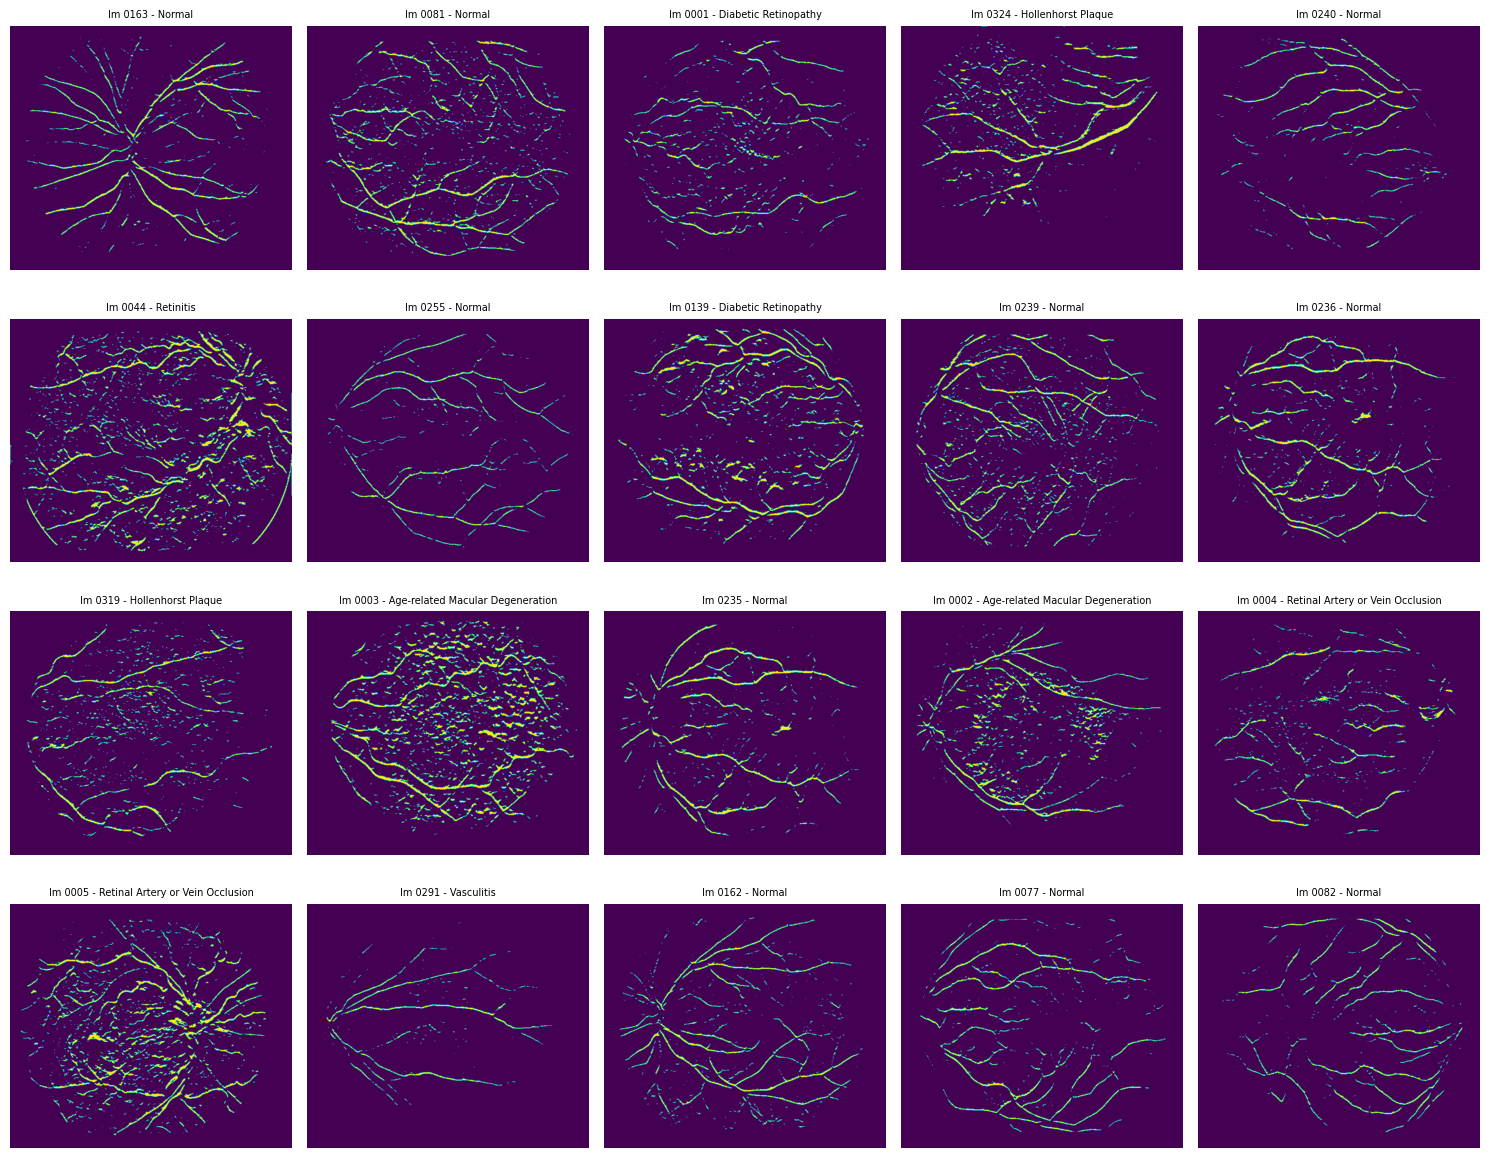

In [ ]:
# Extract Vessel masks for all raw images and visualize them
seg_img_folder_path = '/content/DataChallengeImages/SegmentedImages'  # Adjust the path as needed
os.makedirs(seg_img_folder_path, exist_ok=True)

plt.figure(figsize=(n_cols * 3, n_rows * 3))

# Initialize a list to hold the green channels
Vessel_masks = []

for index, image_file in enumerate(raw_image_files, start=1):
    # Read the image using skimage
    img = io.imread(os.path.join(folder_path_raw_Imgs, image_file))

    # Preprocess img
    img_perprocessed = preprocess_green_channel(img, 5,1, 0.75)

    # Apply Kirsch Templates Analysis
    img_KT_segmented = Kirsch_templates_analysis(img_perprocessed)

    # Enhance segmentation
    img_KT_segmented_enhanced = enhance_segmentation (img_KT_segmented)
    np.max(img_KT_segmented_enhanced)

    # Applly Fuzzy C-Means (FCM) segmentation
    img_FCM_segmented = FCM_segmentatin(img_KT_segmented)

    # Extract ROI mask
    ROI_mask = ROI_masked (img, 20)

    # Apply ROI mask
    Vessel_maks = ROI_mask * img_FCM_segmented

    # save mask
    base_filename = os.path.splitext(image_file)[0]
    segmented_img_file_name = base_filename + '.mh.ppm'
    segmented_file_path = os.path.join(seg_img_folder_path, segmented_img_file_name)

    vessel_mask_uint8 = (Vessel_maks * 255).astype('uint8')
    io.imsave(segmented_file_path, vessel_mask_uint8)


    formatted_base_filename = 'Im' + ' ' + base_filename[2:]


    diagnosis = img_info.loc[img_info['ID'] == formatted_base_filename, 'Diagnosis'].values[0]

    # Add a subplot for the current image
    plt.subplot(n_rows, n_cols, index)
    plt.imshow(Vessel_maks)
    plt.axis('off')  # Hide axes ticks
    plt.title(f"{os.path.basename(formatted_base_filename)} - {diagnosis}", fontsize=7)

# Adjust layout
plt.tight_layout()

Below, I will evaluate segmentation performance by comparing my results with Grader 1 andd 2's segmentations and calculate accuracy, sensitivity, specificity, precision

In [ ]:
# Segmentation performance Evaluation
# Calculate specificity, accuracy, sensitivity
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def calculate_metrics(y_true, y_pred):

    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)  # Also known as recall
    precision = precision_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred)
    return accuracy, sensitivity, specificity, precision, f1


# calculate metrics for comparison with Grader 1 and Grader 2
accuracies_G1, sensitivities_G1, specificities_G1, precisions_G1,f1_scores_G1  = [], [], [], [], []
accuracies_G2, sensitivities_G2, specificities_G2, precisions_G2, f1_scores_G2  = [], [], [], [], []

folder_path_Grader1 = os.path.join(folder_path,'Grader1')
folder_path_Grader2= os.path.join(folder_path,'Grader2')

for index, image_file in enumerate(raw_image_files, start=1):
    # Read the image using skimage
    base_filename = os.path.splitext(image_file)[0]
    segmented_img_file_name = base_filename + '.mh.ppm'
    segmented_file_path = os.path.join(folder_path_raw_Imgs, segmented_img_file_name)

    grader1_img_file_name = base_filename + '.ah.ppm'
    grader2_img_file_name = base_filename + '.vk.ppm'

    seg_img = io.imread(segmented_file_path)
    grader1_img=  io.imread(os.path.join(folder_path_Grader1 , grader1_img_file_name))
    grader2_img=  io.imread(os.path.join(folder_path_Grader2 , grader2_img_file_name))

    # make sure all images have pixel values 0 or 1
    seg_img= np.where(seg_img > 0, 1, 0)
    grader1_img= np.where(grader1_img > 0, 1, 0)
    grader2_img= np.where(grader2_img > 0, 1, 0)


    # flattten images
    seg_img_flat = seg_img.flatten()
    grader1_img_flat = grader1_img.flatten()
    grader2_img_flat = grader2_img.flatten()

    # Calculate metrics for comparison with Grader1
    accuracy, sensitivity, specificity, precision, f1 = calculate_metrics(grader1_img_flat, seg_img_flat)

    # Append metrics to lists
    accuracies_G1.append(accuracy)
    sensitivities_G1.append(sensitivity)
    specificities_G1.append(specificity)
    precisions_G1.append(precision)
    f1_scores_G1.append(f1)

  # Calculate metrics for comparison with Grader2
    accuracy, sensitivity, specificity, precision, f1 = calculate_metrics(grader2_img_flat, seg_img_flat)

    accuracies_G2.append(accuracy)
    sensitivities_G2.append(sensitivity)
    specificities_G2.append(specificity)
    precisions_G2.append(precision)
    f1_scores_G2.append(f1)

# Calculate average metrics
avg_accuracy_G1 = np.mean(accuracies_G1)
avg_sensitivity_G1 = np.mean(sensitivities_G1)
avg_specificity_G1 = np.mean(specificities_G1)
avg_precision_G1 = np.mean(precisions_G1)
avg_f1_scores_G1 = np.mean(f1_scores_G1)

avg_accuracy_G2 = np.mean(accuracies_G2)
avg_sensitivity_G2 = np.mean(sensitivities_G2)
avg_specificity_G2 = np.mean(specificities_G2)
avg_precision_G2= np.mean(precisions_G2)
avg_f1_scores_G2 = np.mean(f1_scores_G1)

print(f"Average Accuracy - Grader 1: {np.round(avg_accuracy_G1,3)}")
print(f"Average Sensitivity- Grader 1: {np.round(avg_sensitivity_G1,3)}")
print(f"Average Specificity- Grader 1: {np.round(avg_specificity_G1,3)}")
print(f"Average Precision- Grader 1: {np.round(avg_precision_G1,3)}")
print(f"Average f1_score- Grader 1: {np.round(avg_f1_scores_G1,3)}")

print(f"Average Accuracy - Grader 2: {np.round(avg_accuracy_G2,3)}")
print(f"Average Sensitivity - Grader 2: {np.round(avg_sensitivity_G2,3)}")
print(f"Average Specificity - Grader 2: {np.round(avg_specificity_G2,3)}")
print(f"Average Precision - Grader 2: {np.round(avg_precision_G2,3)}")
print(f"Average f1_score- Grader 2: {np.round(avg_f1_scores_G2,3)}")


FileNotFoundError: No such file: '/content/DataChallengeImages/Raw images/im0163.mh.ppm'

Visuallize the averaged performance metrics

In [ ]:

# Metric names
metrics_names = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'f1_score']

# Values for Grader 1
grader_1_values = [avg_accuracy_G1, avg_sensitivity_G1, avg_specificity_G1, avg_precision_G1, avg_f1_scores_G1]

# Values for Grader 2
grader_2_values = [avg_accuracy_G2, avg_sensitivity_G2, avg_specificity_G2, avg_precision_G2, avg_f1_scores_G2]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set the positions and width for the bars
bar_width = 0.35
index = np.arange(len(metrics_names))

# Plot data
bar1 = ax.bar(index, grader_1_values, bar_width, label='Grader 1')
bar2 = ax.bar(index + bar_width, grader_2_values, bar_width, label='Grader 2')

# Add some text for labels, title and axes ticks
ax.set_xlabel('Metric')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Segmentation Metrics by Grader')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics_names)
ax.legend()

# Adding the text labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

plt.tight_layout()
plt.show()

Find mean performance metrics for each diagnosis





In [ ]:
grouped_indices = img_info.groupby('Diagnosis').apply(lambda x: x.index.tolist())
print(grouped_indices)

# Accuracy across diagnosis

img_info['Values'] = accuracies_G1

average_Accuracy_per_diagnosis_G1 = img_info.groupby('Diagnosis')['Values'].mean()

plt.figure(figsize=(10, 10))
average_Accuracy_per_diagnosis_G1.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')

plt.title('Average Accuracy per Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Average Accuracy ')
plt.xticks(rotation=45)  # Rotate to avoid overlap
plt.tight_layout()  # Adjust layout
plt.show()

# Sensitivity across diagnosis

img_info['Values'] = sensitivities_G1

average_Sensitivity_per_diagnosis_G1 = img_info.groupby('Diagnosis')['Values'].mean()

plt.figure(figsize=(10, 6))
average_Sensitivity_per_diagnosis_G1.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Average Sensitivity per Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Average Sensitivity ')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.tight_layout()  # Adjust layout
plt.show()


# f1 score across diagnosis

img_info['Values'] = f1_scores_G1

average_Sensitivity_per_diagnosis_G1 = img_info.groupby('Diagnosis')['Values'].mean()

plt.figure(figsize=(10, 6))
average_Sensitivity_per_diagnosis_G1.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Average  f1 score Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Average f1 score ')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.tight_layout()  # Adjust layout
plt.show()